In [166]:
using Oceananigans
using Oceananigans.OutputWriters, Oceananigans.Fields
using Oceananigans.Utils:day, hour, minute, second
using Plots, JLD2, Printf, Oceananigans.Grids

In [167]:
gr()

Plots.GRBackend()

In [168]:
function fileremover(files)
    dir=readdir()
    for filename in files
        if (filename in dir)
            rm(filename)
        end
    end
end

fileremover (generic function with 1 method)

In [175]:
grid1 = RegularCartesianGrid(size=(40,1,50), x=(-0.5,0.5),y=(0,1), z=(-0.15,0.15), topology = (Periodic, Bounded, Bounded))

@inline velforcefuncbot(x,y,t)=-1.0
@inline velforcefunctop(x,y,t)=1.0

u_bcs = UVelocityBoundaryConditions(grid1, bottom = BoundaryCondition(Value,velforcefuncbot), top=BoundaryCondition(Value,velforcefunctop))

t_bcs = TracerBoundaryConditions(grid1, bottom = BoundaryCondition(Value,30.), top=BoundaryCondition(Value,-2.))

model1 = IncompressibleModel(grid=grid1, boundary_conditions=(T=t_bcs,u=u_bcs,),tracers=(:T,:S),closure=IsotropicDiffusivity(ν=2e-4, κ=5e-4))

println(model1)
println(model1.velocities.u)
println(model1.tracers.T)

@inline randvel(x,y,z)=randn()
@inline randtemp(x,y,z)=18+5randn()
@inline randsal(x,y,z)=35+8randn()
set!(model1,T=randtemp,S=randsal,u=randvel,v=randvel,)

wizard=TimeStepWizard(cfl=0.1, Δt=0.0001, max_Δt=10.)

simulation = Simulation(model1, Δt=wizard, stop_time=2minute, iteration_interval=5)

function init_save_some_metadata!(file, model)
    file["author"] = "oofs"
    return nothing
end

fileremover(["VelocityData.jld2","TempData.jld2"])

simulation.output_writers[:velocities] = JLD2OutputWriter(model1, model1.velocities,
                                                          prefix = "VelocityData",
                                                          schedule = TimeInterval(0.5second),
                                                          init = init_save_some_metadata!)

simulation.output_writers[:tracers] = JLD2OutputWriter(model1, model1.tracers,
                                                          prefix = "TempData",
                                                          schedule = TimeInterval(0.5second),
                                                          init = init_save_some_metadata!)



run!(simulation)

IncompressibleModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RegularCartesianGrid{Float64, Periodic, Bounded, Bounded}(Nx=40, Ny=1, Nz=50)
├── tracers: (:T, :S)
├── closure: IsotropicDiffusivity{Float64,NamedTuple{(:T, :S),Tuple{Float64,Float64}}}
├── buoyancy: SeawaterBuoyancy{Float64,LinearEquationOfState{Float64},Nothing,Nothing}
└── coriolis: Nothing
Field located at (Face, Cell, Cell)
├── data: OffsetArrays.OffsetArray{Float64,3,Array{Float64,3}}, size: (42, 3, 52)
├── grid: RegularCartesianGrid{Float64, Periodic, Bounded, Bounded}(Nx=40, Ny=1, Nz=50)
└── boundary conditions: x=(west=Periodic, east=Periodic), y=(south=ZeroFlux, north=ZeroFlux), z=(bottom=Value, top=Value)
Field located at (Cell, Cell, Cell)
├── data: OffsetArrays.OffsetArray{Float64,3,Array{Float64,3}}, size: (42, 3, 52)
├── grid: RegularCartesianGrid{Float64, Periodic, Bounded, Bounded}(Nx=40, Ny=1, Nz=50)
└── boundary conditions: x=(west=Periodic, east=Periodic), y=(south=ZeroFlux, north=ZeroFlu

┌ Info: Simulation is stopping. Model time 2.000 minutes has hit or exceeded simulation stop time 2 minutes.
└ @ Oceananigans.Simulations /Users/jerobinett/.julia/packages/Oceananigans/RxUYW/src/Simulations/run.jl:40


┌ Info: Saved animation to 
│   fn = /Users/jerobinett/Desktop/JuliaPractice/Couette U-Velocity.gif
└ @ Plots /Users/jerobinett/.julia/packages/Plots/5ItHH/src/animation.jl:104


Plots.AnimatedGif("/Users/jerobinett/Desktop/JuliaPractice/Couette U-Velocity.gif")
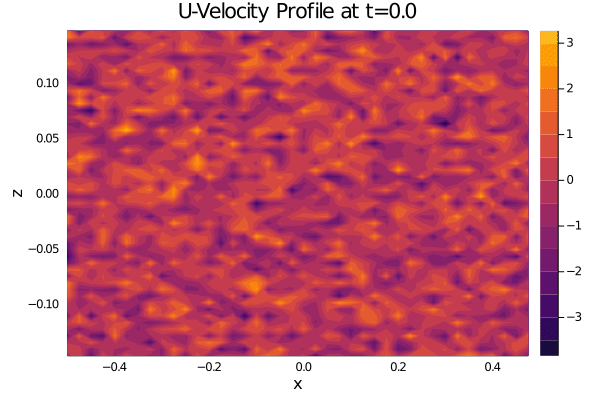

In [176]:
x, y, z = nodes(model1.velocities.u)
let

    file = jldopen(simulation.output_writers[:velocities].filepath)
    iterations = parse.(Int, keys(file["timeseries/t"]))
    anim = @animate for (i, iter) in enumerate(iterations)

        uvel = transpose(file["timeseries/u/$iter"][:,1,:])
        timeofthing=file["timeseries/t/$iter"]

        y=contourf(x, z, uvel, title = "U-Velocity Profile at t=$timeofthing",linewidth=0,xlabel = "x",ylabel = "z",levels=-5:0.5:5)
    end
    gif(anim, "Couette U-Velocity.gif", fps = 24)
end

┌ Info: Saved animation to 
│   fn = /Users/jerobinett/Desktop/JuliaPractice/Couette Temperature.gif
└ @ Plots /Users/jerobinett/.julia/packages/Plots/5ItHH/src/animation.jl:104


Plots.AnimatedGif("/Users/jerobinett/Desktop/JuliaPractice/Couette Temperature.gif")
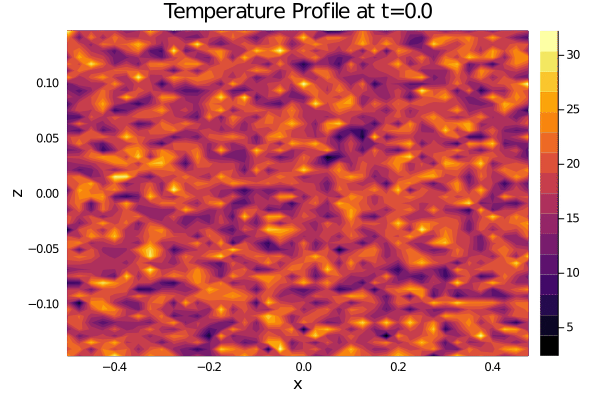

In [177]:
let
    file = jldopen(simulation.output_writers[:tracers].filepath)
    iterations = parse.(Int, keys(file["timeseries/t"]))
    anim = @animate for (i, iter) in enumerate(iterations)

        T = transpose(file["timeseries/T/$iter"][:,1,:])
        timeofthing=file["timeseries/t/$iter"]

        contourf(x, z, T, title = "Temperature Profile at t=$timeofthing",linewidth=0,xlabel = "x",ylabel = "z")
    end
    gif(anim, "Couette Temperature.gif", fps = 24)
end